In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path 
from tabulate import tabulate
from shapely import Point, MultiPoint, LineString, affinity

In [2]:
file = Path().resolve()
parent, root = file.parent, file.parents[1]

# add the location of the root folder (zeroheliumkit) to the PATH
sys.path.append(str(root))

# Additionally remove the current file's directory from sys.path
try:
    sys.path.remove(str(parent))
except ValueError: # Already removed
    pass

In [3]:
from zeroheliumkit import (Entity, uChannelsAngle, Taper, SpiralInductor, IDC, GeomCollection,
                           ArcLine, Meander, Rectangle)
from zeroheliumkit.src.functions import merge_lines_with_tolerance
from zeroheliumkit.src.settings import COLORS, SIZE, SIZE_L
from zeroheliumkit.helpers.resonator_calc import *

%matplotlib inline
%config InlineBackend.figure_format='retina'

### **RES uChannels** 

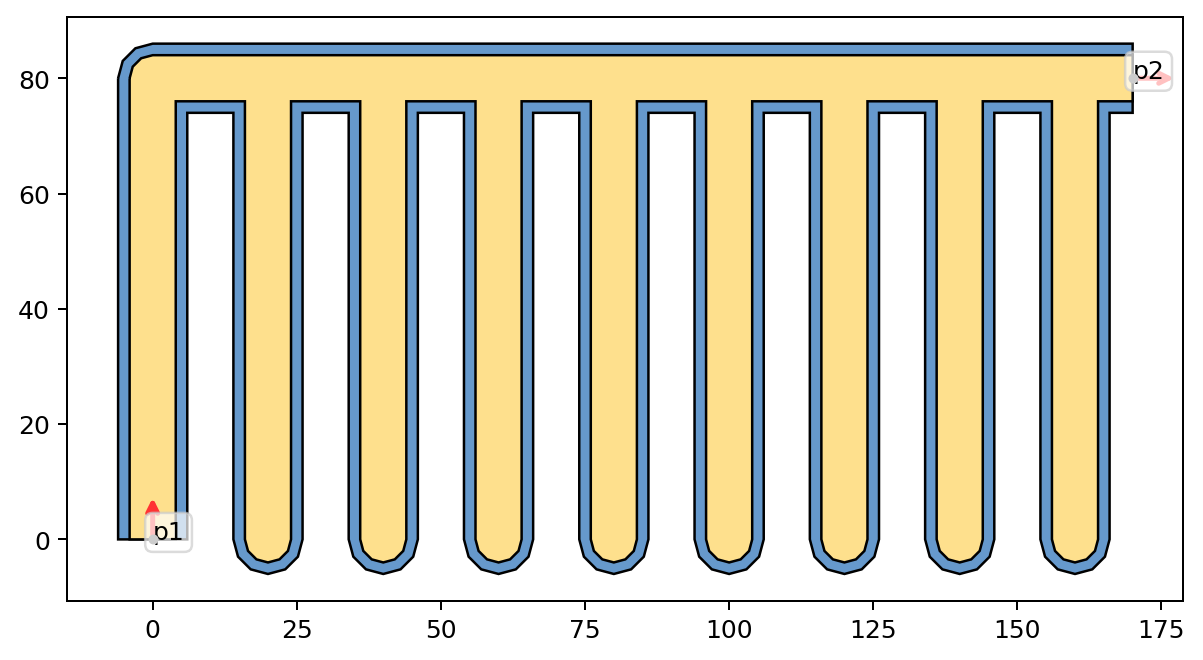

In [4]:
RES_layer_info = {"metal": 8,
                  "etch": 12}
reservior = uChannelsAngle(length=80, 
                           spacing=20,
                           num=9,
                           angle=0,
                           layers=RES_layer_info,
                           alabel=("p1", "p2"))

fig = plt.figure(1, figsize=SIZE, dpi=90)
ax = fig.add_subplot(111)
reservior.plot(ax=ax, layer=["etch", "metal", "anchors"], color=COLORS)
plt.gca().set_aspect('equal')
plt.show()

### **Taper**

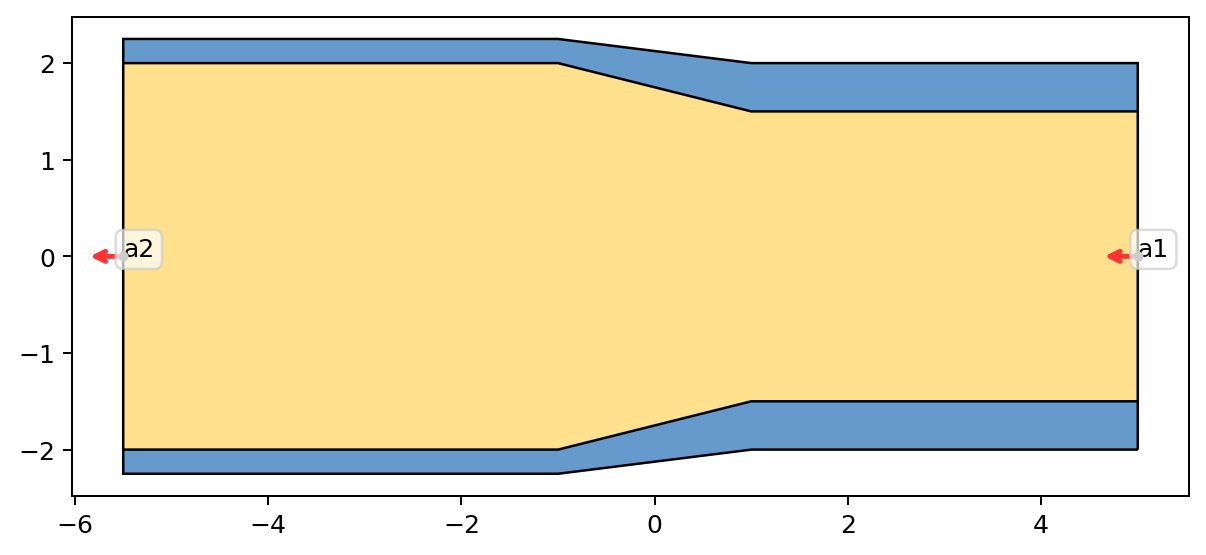

In [5]:
layer_info = {"metal": (3, 4),
              "etch": (3 + 1, 4 + 0.5)}
tp = Taper(length=2,
           layers=layer_info,
           alabel=("a1","a2"))

tp.scale(-1, 1, origin=(0,0))

fig = plt.figure(1, figsize=SIZE, dpi=90)
ax = fig.add_subplot(111)
tp.plot(ax=ax, layer=["etch", "metal", "anchors"], color=COLORS)
plt.gca().set_aspect('equal')
plt.show()

### **Spiral Inductor** <a name="introduction"></a>

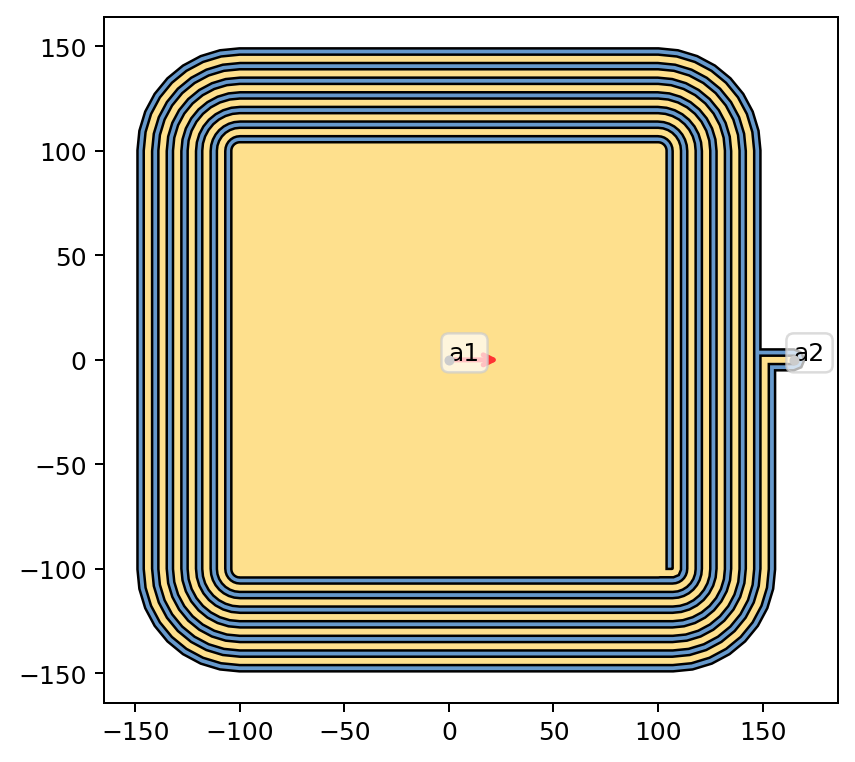

In [6]:
layer_info = {"metal": 4,
              "etch": 10}
spI = SpiralInductor(size = 200, 
                    width = 4, 
                    gap = 3, 
                    num_turns = 6, 
                    smallest_section_length = 0.5,
                    layers = layer_info,
                    alabel=("a1", "a2"))

fig = plt.figure(1, figsize=SIZE, dpi=90)
ax = fig.add_subplot(111)
spI.plot(ax=ax, layer=["etch", "metal", "anchors"], color=COLORS)
plt.gca().set_aspect('equal')
plt.show()
#spI.save_to_file("spiral_inductor")

### **IDC**

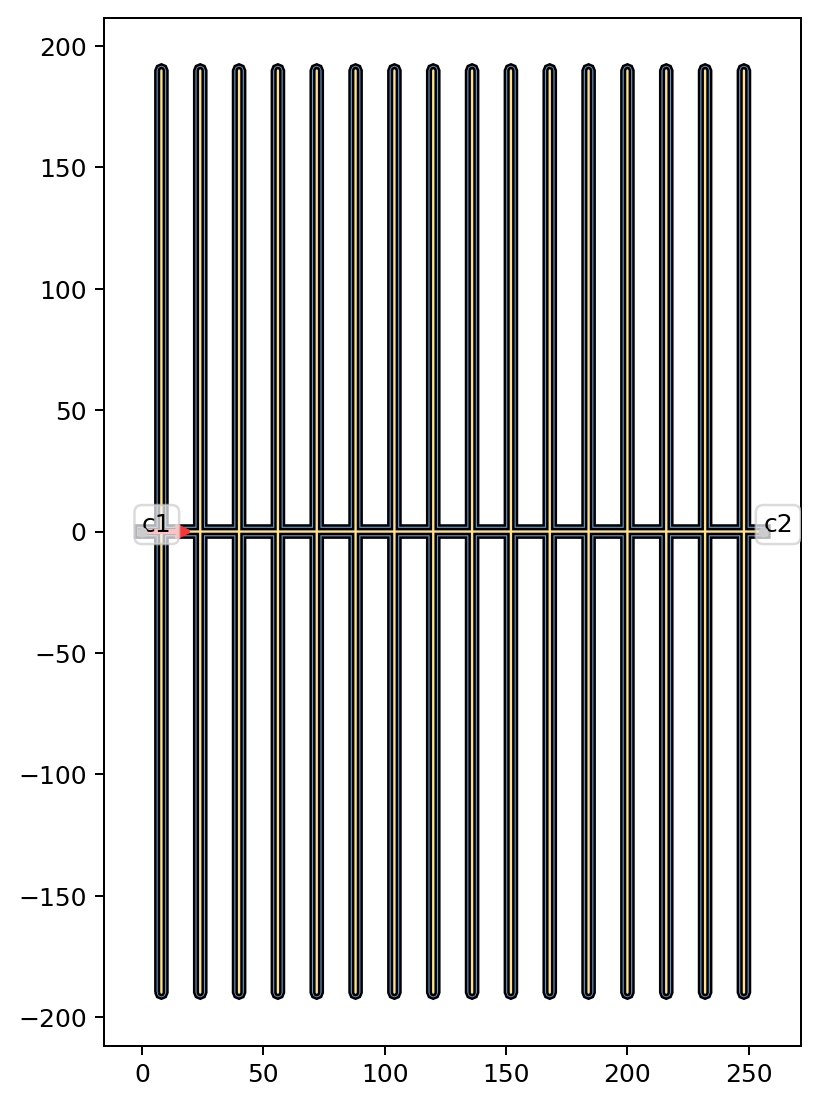

In [7]:
layer_info = {"metal": 2,
              "etch": 5}
idc = IDC(length=190, 
          spacing=16, 
          num=15, 
          layers=layer_info,
          alabel=("c1", "c2"))

fig = plt.figure(1, figsize=SIZE_L, dpi=90)
ax = fig.add_subplot(111)
idc.plot(ax=ax, layer=["etch", "metal", "anchors"], color=COLORS)
plt.gca().set_aspect('equal')
plt.show()

### **CPW Resontaor**

In [8]:
def construct_resonator_skeletone(params: dict, init_point: Point) -> LineString:
    
    r = params['geometry']['radius']
    n = params['geometry']['num']
    w = params['geometry']['w']
    g = params['geometry']['g']
    b_x = params['geometry']['box_x'] - 2 * r
    b_y = params['geometry']['box_y']/2 - r
    x0 = init_point.x
    y0 = init_point.y
    
    eps_eff = calculate_eps_eff_from_geometry(substrate_epsR = params["substrate_eps"],
                                              w = w,
                                              g = g,
                                              substrate_height = params["substrate_h"])
    Z0 = calculate_impedance(w, g, eps_eff)
    length = calculate_resonator_length(params["type"], eps_eff, params["frequency"])
    print(tabulate([["f0", "length", "eps_eff", "impedance"], 
                    [params["frequency"], round(length, 2), round(eps_eff, 2), round(Z0, 2)]]))
    
    d_e = b_y - 4 * r * n
    d_b = (length/2 - (b_y + pi * r + b_x + n * 2 * pi * r + d_e))/2/n
    if d_b < 0 or d_e < 0:
        raise Exception("Incorrect geometry input. Choose different 'radius', 'x_length', 'y_height' or 'num'")

   
    e = Entity()
    e.add_line(LineString([(x0, y0), (x0, b_y)]))
    e.add_line(ArcLine(r, 0, r, 180, 90, 50))
    e.add_line(LineString([(0, 0), (b_x - d_b/2, 0)]))
    for i in range(n):
        e.add_line(Meander(d_b, r, direction=-90, num_segments=100))
    e.add_line(LineString([(0, 0), (d_b/2, 0)]))
    e.add_line(ArcLine(0, -r, r, 90, 0, 50))
    e.add_line(LineString([(0, 0), (0, -d_e)]))

    e_mirrored = affinity.scale(e.skeletone, xfact=1, yfact=-1, origin=(0,0))

    return merge_lines_with_tolerance(e.skeletone, e_mirrored, tol=1e-2)

In [9]:
params = {'type': 0.5,
        'frequency': 6.5,
        'substrate_eps': 11,
        'substrate_h': 1500,
        'geometry': {'w': 10,
                        'g': 4.5,
                        'box_x': 1400, 
                        'box_y': 1200,
                        'radius': 60, 
                        'num': 2}}
geom_params = params["geometry"]
resonator_sk = construct_resonator_skeletone(params, Point(0, 20))

resonator = GeomCollection(layers={"top": resonator_sk.buffer(geom_params["w"], cap_style="flat", join_style="mitre"),
                                   "gnd": resonator_sk.buffer(geom_params["w"] + 2*geom_params["g"], cap_style="flat", join_style="mitre")})

#p1 = Point(0, 20)
#p2 = Point(geom_params["box_x"] - geom_params["radius"], geom_params["box_y"]/2 - geom_params["radius"])

#resonator.add_anchor([p1, p2])

---  -------  -------  ---------
f0   length   eps_eff  impedance
6.5  9414.63  6.0      47.72
---  -------  -------  ---------


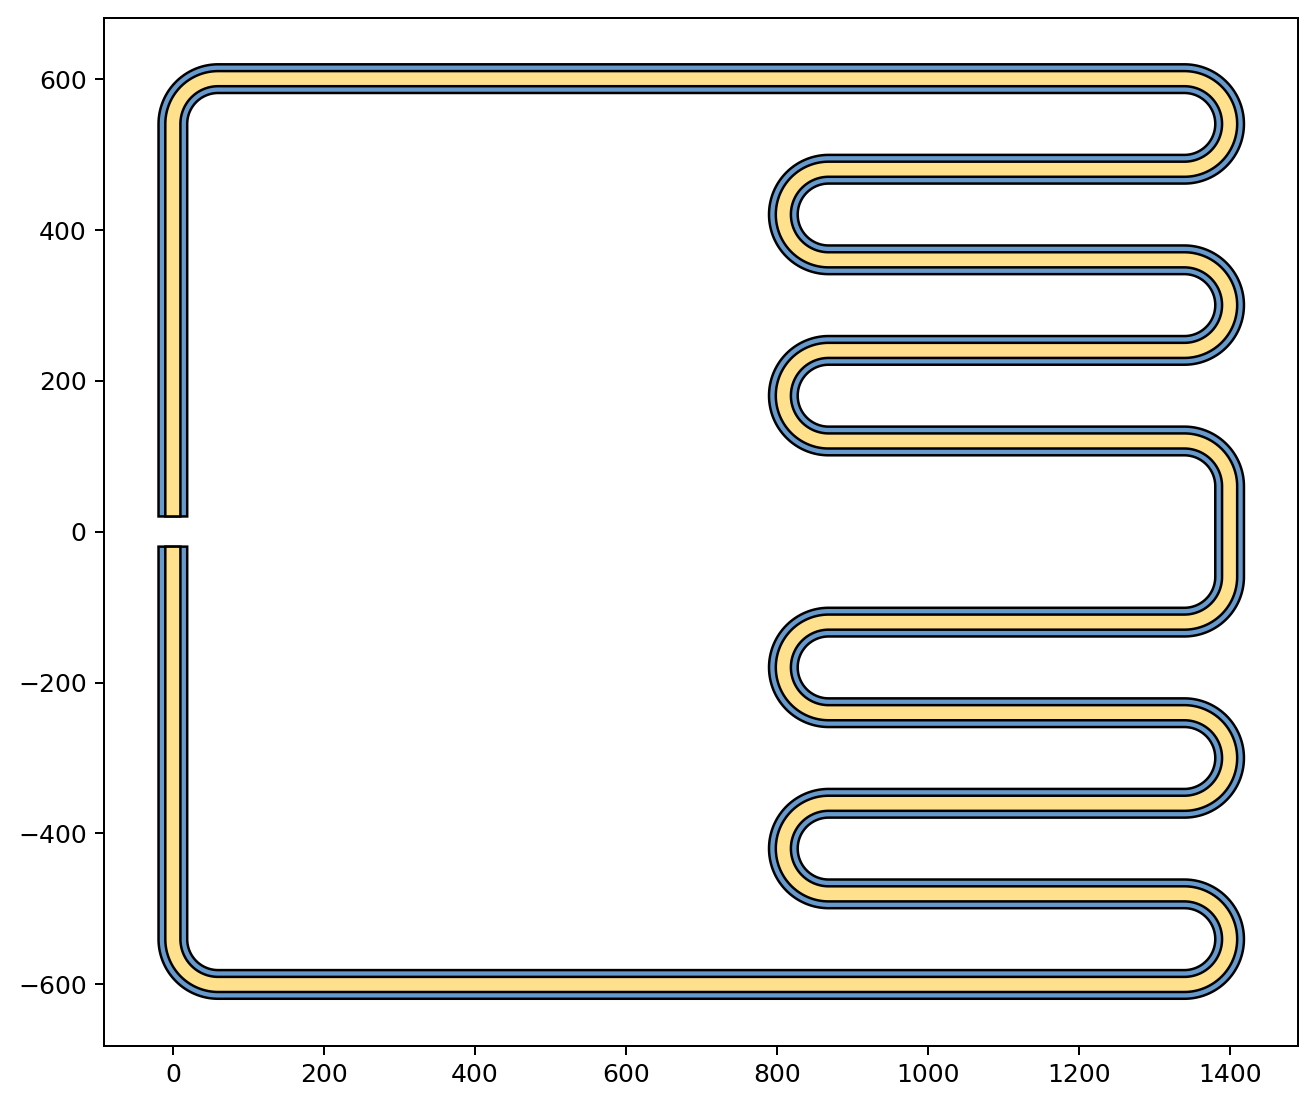

In [10]:
fig = plt.figure(1, figsize=SIZE_L, dpi=90)
ax = fig.add_subplot(111)
resonator.plot(ax=ax, layer=["gnd", "top", "anchors"], color=COLORS)
plt.gca().set_aspect('equal')
plt.show()

### **CPW Launcher**

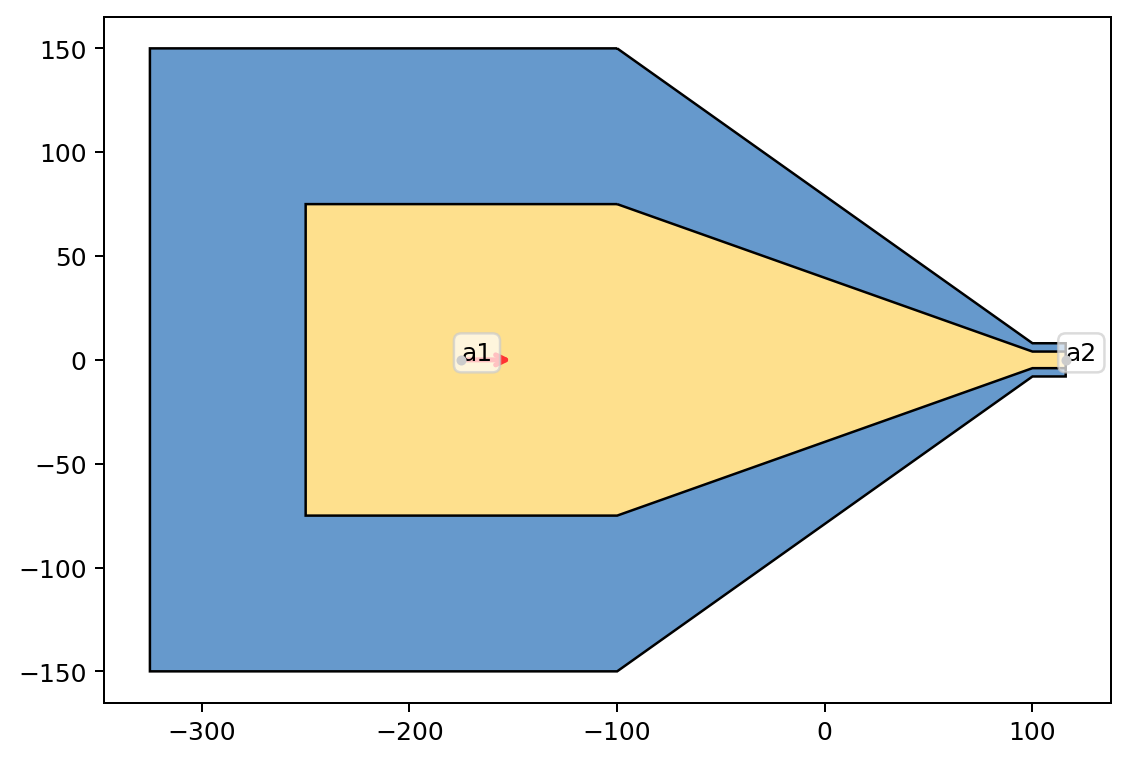

In [14]:
cpwlauncher = Taper(length = 200,
                    layers = {"top": (150, 8),
                              "gnd": (300, 16)},
                              alabel=("a1","a2"))
cpwlauncher.cut_polygon("top", Rectangle(150, 200, (-325,0)))
cpwlauncher.cut_polygon("gnd", Rectangle(75, 400, (-325-75/2,0)))
cpwlauncher.get_anchor("a1").move(225)

fig = plt.figure(1, figsize=SIZE, dpi=90)
ax = fig.add_subplot(111)
cpwlauncher.plot(ax=ax, layer=["gnd", "top", "anchors"], color=COLORS)
plt.gca().set_aspect('equal')
plt.show()